# Importing Libraries

In [25]:
import pandas as pd
import matplotlib as plt
import statsmodels.api as sm

# Loading the Dataset

Data is downloaded to the `/data` subdirectory of the root project folder. We will use `pandas` to create a data frame with this data. 

In [12]:
data = pd.read_csv('data/AirPassengers.xls', index_col=0)
data.columns = [ 'Count' ] # Renaming `#Passengers` -> `Count` for convenience
data.head()

,Count
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


We see that the dataset looks relatively simple. It contains monthly data about the number of air passengers. Let's see more detailed description of the data using `pandas.describe()`:

In [3]:
data.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


Having taken a better look we can note down a couple observations:
 - There are 144 observations
 - The distribution is centered around 280
 - The distribution is skewed towards larger values jugding from **quartiles** and **min-max** range

Let's import libraries required for performing the analysis and forecasting outlined in the paper.

# Time Series Modelling - ARIMA

We will fit a simple **A**uto**R**egressive **I**ntegrate **M**oving **A**verage, or **ARIMA**, model to our time series of air passengers.

First, we should plot the time series and it's first difference, as is customary:

In [15]:
# First difference is computed by diffing values with shifted values. We then fill NAs with 0s to
# handle the first difference.
data[ 'Diff' ] = (data[ 'Count' ] - data[ 'Count' ].shift(1)).fillna(0)
data.head()

,Count,Diff
Month,,
1949-01,112,0.0
1949-02,118,6.0
1949-03,132,14.0
1949-04,129,-3.0
1949-05,121,-8.0


array([<Axes: xlabel='Month'>, <Axes: xlabel='Month'>], dtype=object)

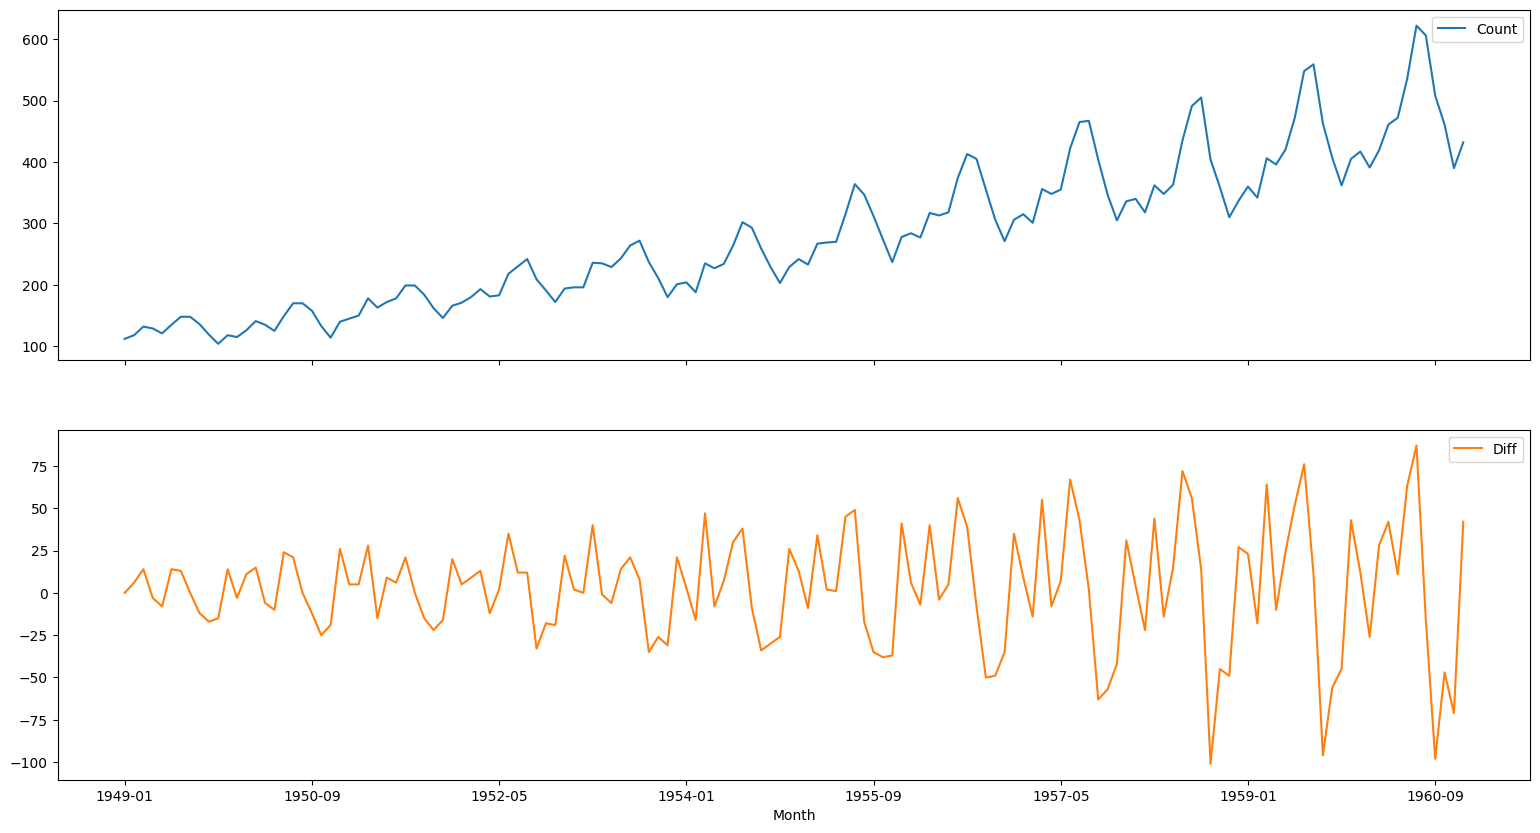

In [18]:
data.plot(figsize=(19, 10), subplots=True)

## Visual Inspection

At the first glance we see that the data does not contain missing values. It's a discrete series, because we sample our values monthly. It appears seasonal, which is in line with the meaning of the values in the data frame - they reflect the number of air passengers, so it's natural that we observe more passengers during, for example, summer.

## Stationarity

We should check if the series is stationary. As per visual inspection we see that it should not be. We will use the <ins>**A**ugumented **D**ickey-**F**uller</ins> (**ADF**) test ([*Wikipedia* link](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)), which is a part of the `statsmodels` library.

In [40]:
# Small helper function for performing the DF test on a time series. 
def ADF(series):
    (adf_test, adf_p) = sm.tsa.stattools.adfuller(data[ 'Count' ])[:2]
    print(f"ADF Test Statistic = {adf_test}, p-value = {adf_p}")

ADF(data[ 'Count' ])

ADF Test Statistic = 0.8153688792060655, p-value = 0.9918802434376413


Because the *p-value* is outside the critical region, we **fail to reject the null** hypothesis about the stationarity of the series. This is in line with our initial expectations. We will assume that the series is non-stationary.

For completeness, let's also check the stationarity of the series of first differences:

In [41]:
ADF(data[ 'Diff' ])

ADF Test Statistic = 0.8153688792060655, p-value = 0.9918802434376413


Similarly, we again **fail to reject the null** hypothesis and have to assume the non-stationarity of the series of first differences.

### Transforming the Series to be Stationary

The authors of the paper decide that the best approach is to use a *logarithmic transformation* to obtain a stationary time series. The other option that was listed was to difference the time series - we showed that this method will be **unsuccessful** above.

Other steps that were taken by the authors include: differencing and removing seasonality. They **did not** mention how was the seasonality removed - we can only guess here and do our own estimations. 